In [1]:

# IMPORT LIBRARIES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For statistical analysis
import scipy.stats as stats

# For ML model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# For checking multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:

# UPLOAD DATASET


from google.colab import files
uploaded = files.upload()

df = pd.read_csv("Advertising.csv")
df.head()

Saving Advertising.csv to Advertising (1).csv


,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [3]:
# Shape of dataset
print("Dataset Shape:", df.shape)

# Data types
df.info()

# Statistical summary (Mean, Std, Min, Max)
df.describe()

Dataset Shape: (200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


,Unnamed: 0,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


In [4]:
df.isnull().sum()

,0
Unnamed: 0,0
TV,0
Radio,0
Newspaper,0
Sales,0


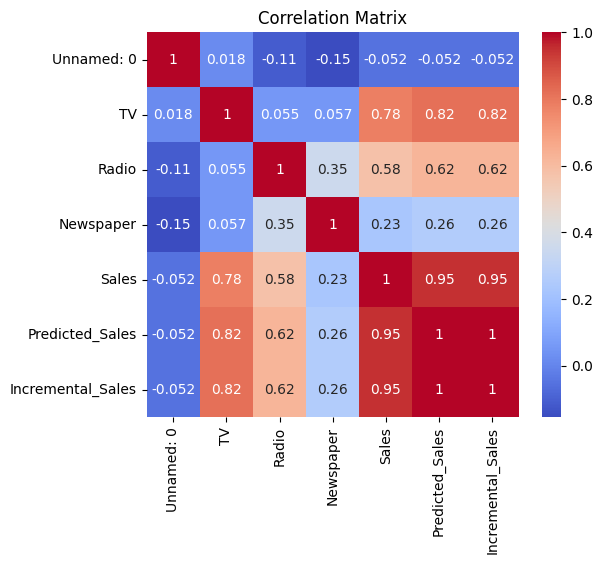

In [21]:
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.savefig("correlation_heatmap.png", dpi=300)
plt.show()

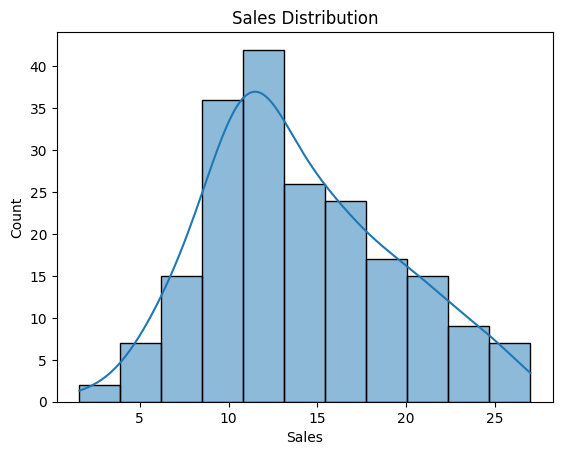

P-value: 0.0016828565078876381
Data not normally distributed


In [22]:
# Check normal distribution of Sales
sns.histplot(df['Sales'], kde=True)
plt.title("Sales Distribution")
plt.savefig("sales_distribution.png", dpi=300)
plt.show()

# Shapiro-Wilk Normality Test
stat, p = stats.shapiro(df['Sales'])
print("P-value:", p)

if p > 0.05:
    print("Data looks normally distributed")
else:
    print("Data not normally distributed")

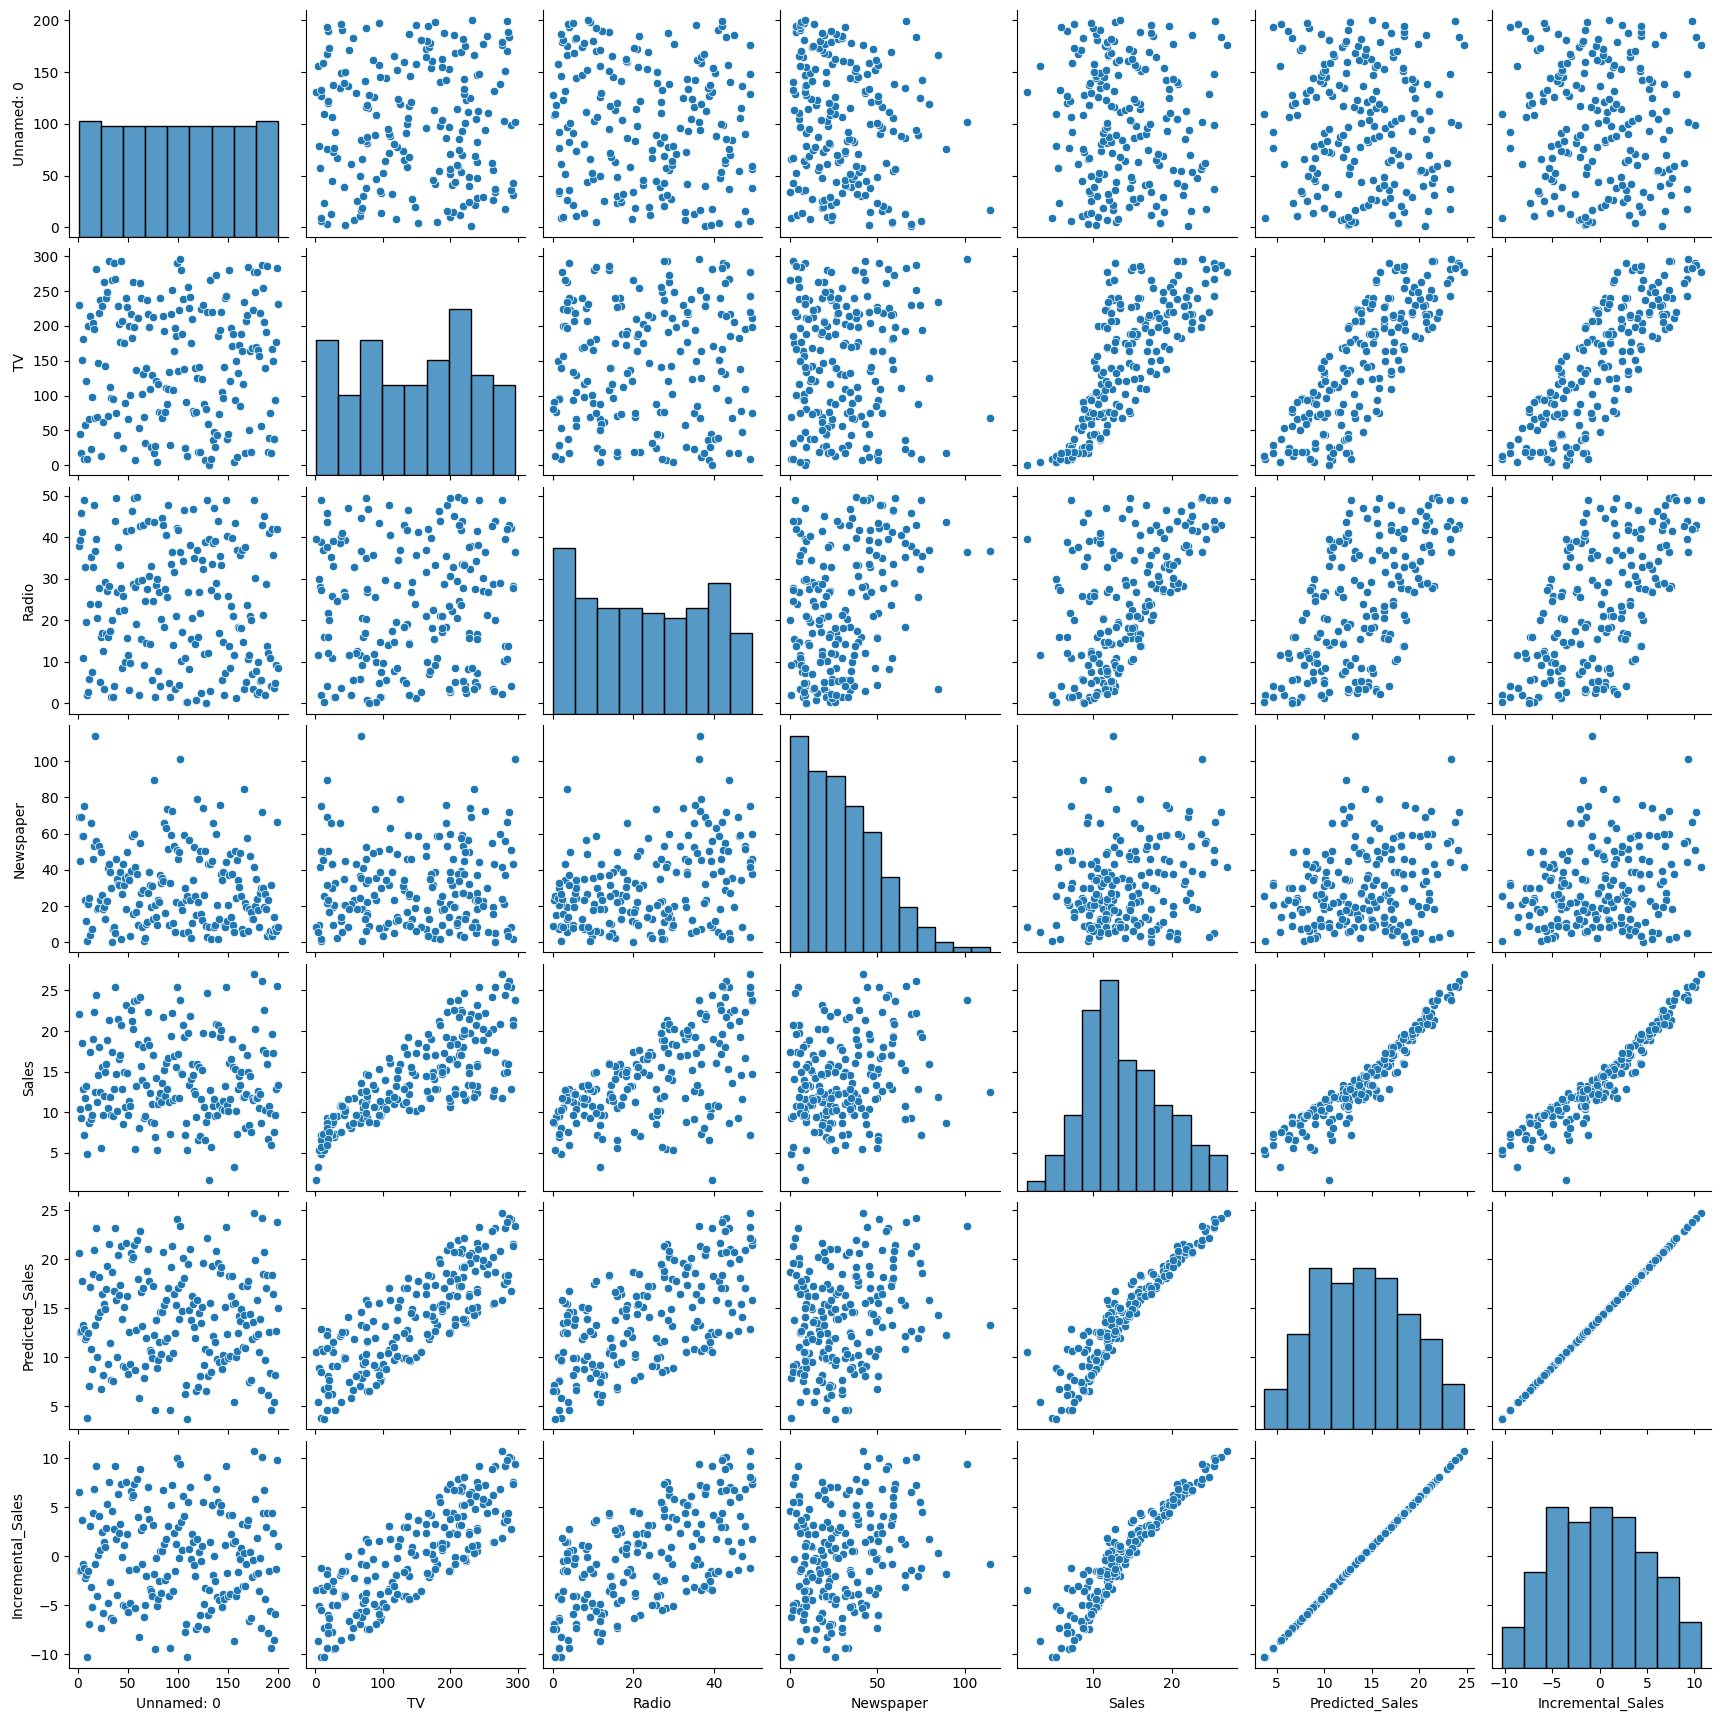

In [23]:
sns.pairplot(df)
plt.savefig("pairplot.png")
plt.show()

In [8]:
# Independent variables
X = df[['TV','Radio','Newspaper']]

# Dependent variable
y = df['Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
# Add constant for statsmodels
X_const = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i)
                   for i in range(X_const.shape[1])]

vif_data

,Feature,VIF
0,const,6.848900
1,TV,1.004611
2,Radio,1.144952
3,Newspaper,1.145187


In [10]:
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

In [11]:
print("R2 Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R2 Score: 0.899438024100912
MAE: 1.4607567168117603
MSE: 3.1740973539761033


In [12]:
# Adjusted R2 calculation
n = X_test.shape[0]      # number of observations
p = X_test.shape[1]      # number of predictors

r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1-r2)*(n-1)/(n-p-1)

print("Adjusted R2:", adj_r2)

Adjusted R2: 0.8910578594426547


In [13]:
coefficients = pd.DataFrame({
    "Channel": X.columns,
    "Impact": model.coef_
})

coefficients

,Channel,Impact
0,TV,0.044730
1,Radio,0.189195
2,Newspaper,0.002761


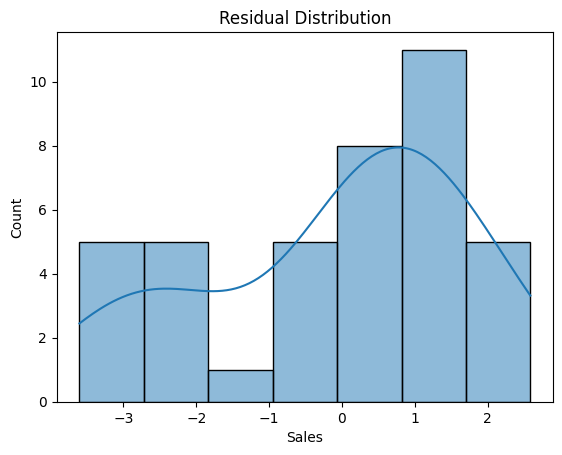

In [24]:
residuals = y_test - y_pred

sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.savefig("residual_distribution.png", dpi=300)
plt.show()

In [15]:
# Predict full dataset sales
df['Predicted_Sales'] = model.predict(X)

# Calculate incremental sales
df['Incremental_Sales'] = df['Predicted_Sales'] - df['Sales'].mean()

# ROI for each channel
roi = {}

for col in X.columns:
    roi[col] = df['Incremental_Sales'].sum() / df[col].sum()

roi

{'TV': np.float64(0.00013264355414942765),
 'Radio': np.float64(0.000838387199579488),
 'Newspaper': np.float64(0.0006383530736079471)}

In [16]:
# Add constant
X_sm = sm.add_constant(X)

# Fit OLS model
model_sm = sm.OLS(y, X_sm).fit()

print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Tue, 24 Feb 2026   Prob (F-statistic):           1.58e-96
Time:                        15:56:21   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9389      0.312      9.422      0.0

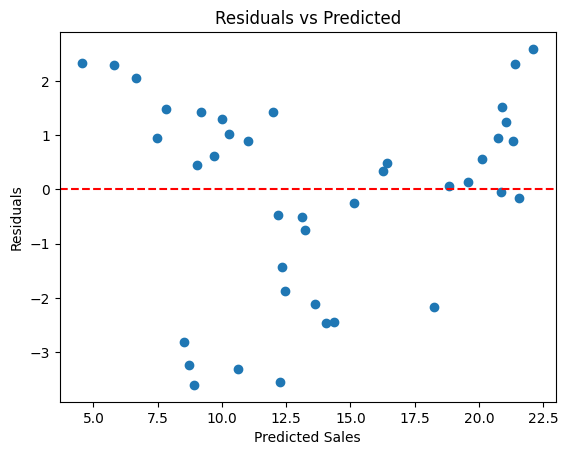

In [25]:
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.savefig("residual_vs_predicted.png", dpi=300)
plt.show()

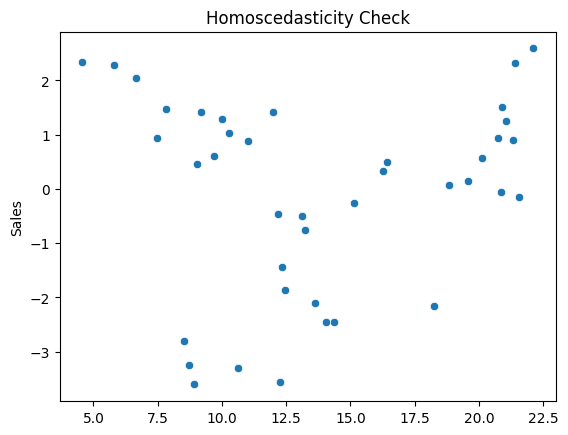

In [26]:
sns.scatterplot(x=y_pred, y=residuals)
plt.title("Homoscedasticity Check")
plt.savefig("Homoscedasticity Check.png", dpi=300)
plt.show()

In [19]:
elasticity = model.coef_ * (X.mean() / y.mean())
elasticity_df = pd.DataFrame({
    "Channel": X.columns,
    "Elasticity": elasticity
})
elasticity_df

,Channel,Elasticity
TV,TV,0.469042
Radio,Radio,0.313884
Newspaper,Newspaper,0.006016


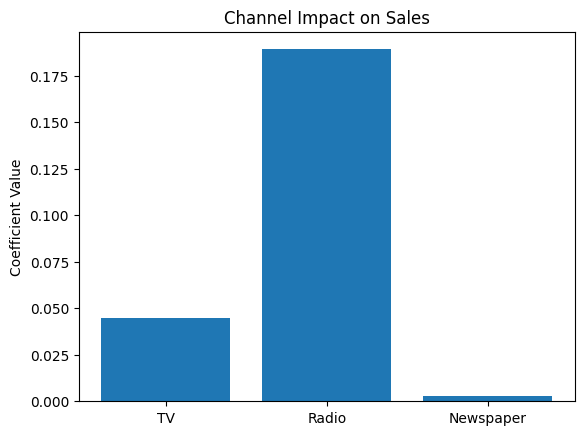

In [27]:
plt.bar(X.columns, model.coef_)
plt.title("Channel Impact on Sales")
plt.ylabel("Coefficient Value")

plt.savefig("channel_impact.png", dpi=300)
plt.show()

# 📊 Marketing Mix Modeling - Business Insights

##  Objective
The objective of this project is to quantify the impact of different marketing channels on sales and recommend optimal budget allocation.



## Key Findings

- Radio advertising has the highest positive impact on sales.
- TV advertising shows moderate contribution.
- Newspaper advertising has minimal effect on sales.
- Model R² score indicates strong explanatory power.



## ROI Analysis

- Radio delivers the highest return per unit spend.
- Newspaper has the lowest ROI and can be reduced.
- Reallocating 15% budget from Newspaper to Radio could improve marketing efficiency.



## Statistical Validation

- Assumptions of linear regression were tested.
- Multicollinearity checked using VIF.
- Residuals approximately normally distributed.
- No significant overfitting observed.



##  Business Recommendation

- Increase investment in high-ROI channels (Radio).
- Reduce spending on low-impact channels (Newspaper).
- Continuously monitor campaign performance using data-driven strategies.